#  Compare Model Zoo Benchmark performance between Intel optimized and stock PyTorch

This jupyter notebook will help you evaluate performance benefits from Intel-optimized PyTorch which uses Intel-PyTorch-Extension package to boost the performance.
The notebook will show users a bar chart like below for performance comparison among Stock and Intel PyTorch.

Please change kernels between intel-torch and stock-torch. Run last cell only when you're done running both kernels.

<img src="images\perf_compare.png"  />

# Get Platform Information 

In [1]:
# ignore all warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
from profiling.profile_utils import PlatformUtils
plat_utils = PlatformUtils()
plat_utils.dump_platform_info()

/tmp/models/docs/notebooks/perf_analysis/pytorch/profiling/../../../../../benchmarks/common
==================== CPU Info ====================
Physical cores per socket: 28
Total physical cores: 56
Max Frequency: 4000.0
Min Frequency: 1000.0
Socket Number: 2
==================== Memory Information ====================
Total:  251 GB


<a id='section_1'></a>
# Section 1: Run the benchmark on the selected Jupyter Kernels

## Step 1: Check PyTorch version and IPEX enablement

In [3]:
import torch
print ("We are using PyTorch version", torch.__version__)
try:
    import intel_pytorch_extension as ipex
    print("IPEX version: {}".format(ipex.__version__))
    has_ipex = True
except ImportError:
    print("WARNING: IPEX not available")
    has_ipex = False

We are using PyTorch version 1.7.0a0+e85d494
IPEX version: 1.2.0


## Step 2: Configure parameters for pytorch's launch utility according to the selected Topology

### Step 2.1: List out the supported topologies

In [4]:
import sys
from profiling.profile_utils import ConfigFile

accuracy_only=False

config = ConfigFile()
sections = config.read_supported_section(accuracy_only=accuracy_only)
print("Supported topologies: ")
index =0 
for section in sections:
    print(" %d: %s " %(index, section))
    index+=1

Supported topologies: 
 0: resnet50 infer fp32 
 1: vgg16 infer fp32 


### Step 2.2: Pick a topology. 
#### ACTION : Please select one supported topology and change topo_index accordingly

In [5]:
# User picks a topology, Batch Size, and number of required threads
## USER INPUT
topo_index=0

#### List out the selected topology name

In [6]:
if topo_index >= len(sections):
    print("ERROR! please input a topo_index within range")
else:
    topology_name=sections[topo_index]
    print(topology_name)

resnet50 infer fp32


In [7]:
import os
# Users should change ModelZooRoot path according to their environment
## USER INPUT
current_path = os.getcwd()
os.environ['ModelZooRoot'] = current_path + "/../../../../"
print(os.environ['ModelZooRoot'])

/tmp/models/docs/notebooks/perf_analysis/pytorch/../../../../


#### Check those mandatory python scripts after users assign ModelZooRoot and ProfileUtilsRoot

In [8]:
sys.path.append(os.environ['ModelZooRoot']+os.sep+'benchmarks/common/')
from platform_util import CPUInfo 
cpu_info = CPUInfo()

In [9]:
import psutil
import subprocess
import os
cpu_count = cpu_info.cores_per_socket
cpu_socket_count =  cpu_info.sockets
print("CPU count per socket:" ,  cpu_count ," \nSocket count:",cpu_socket_count)

CPU count per socket: 28  
Socket count: 2


#### ACTION: Users can change the value of thread_number and batch_size to see different performance
1. thread_number: the value will apply to num_cores parameters in launch_benchmark.py  
2. utilized_socket_number:  the value will apply to the socket-id parameter in launch_benchmark.py 
3. num_inter_threads: the value will  apply to the num-inter-threads parameter in launch_benchmark.py 
4. num_intra_threads: the value will  apply to the num-intra-threads parameter in launch_benchmark.py 
5. batch_size: the value will apply to the batch_size parameter in launch_benchmark.py 
6. log_folder: the folder where the logs are stored.

In [10]:
## USER INPUT
thread_number=1 
utilized_socket_number=2 #cpu_socket_count
num_inter_threads = utilized_socket_number
num_intra_threads = thread_number
batch_size=32
log_folder=os.getcwd() + os.sep + "logs"

In [11]:
import os
current_path = os.getcwd()
log_dir = os.path.join(current_path, "logs")
log_filename = topology_name.replace(' ', '_') + '.log'
log_path = os.path.join(log_dir, log_filename)
from torch.distributed import launch

### Step 2.3: Prepare pre-trained model and model parameters for running the benchmark
1. Get related parameters according to selected topology
2. Get pretrained model if needed

In [12]:
config = ConfigFile()
configvals = []
# Get common parameters according to users' inputs
params = ["torch.distributed.launch"]
params.extend(config.get_launch_parameters(configvals, thread_number=thread_number,
                                socket_number=utilized_socket_number, num_inter_threads=num_inter_threads,
                                num_intra_threads=num_intra_threads,
                                accuracy_only=False))
main_script = os.environ['ModelZooRoot']+os.sep+'models/image_recognition/pytorch/common/main.py'
params += [main_script]
params.extend(config.get_main_parameters(topology_name = topology_name.split(" ")[0], mode = "infer",
                                         batch_size=batch_size, has_ipex = has_ipex,
                                         precision="fp32", warmup_iter=30, log_path=log_path))

    
sys.argv=params
print(sys.argv)

['torch.distributed.launch', '--nnodes=2', '--node_rank=2', '--nproc_per_node=1', '--use_env', '/tmp/models/docs/notebooks/perf_analysis/pytorch/../../../..//models/image_recognition/pytorch/common/main.py', '--batch-size', '32', '--arch', 'resnet50', '--dummy', '--evaluate', '--pretrained', '--ipex', '--precision', 'fp32', '--jit', '--warmup-iterations', '30', '--log-path=/tmp/models/docs/notebooks/perf_analysis/pytorch/logs/resnet50_infer_fp32.log']


### Step 2.4: Create a CSV file to log the performance numbers

In [13]:
from profiling.profile_utils import PerfPresenter
job_type = topology_name.split(' ')[1]#'inference'
csv_fname=job_type+'_'+topology_name.replace(' ', '_')+'.csv'
perfp=PerfPresenter()
perfp.create_csv_logfile(job_type, csv_fname)

file exists


## Step 3:  Run the benchmark 

In [14]:
launch.main()

## Step 4: Parse output for performance number

#### Found the file path of the related runtime log.

In [15]:
# identify the path of the latest log file
configvals=config.read_config(topology_name)
used_logpath = log_path
print(used_logpath)

/tmp/models/docs/notebooks/perf_analysis/pytorch/logs/resnet50_infer_fp32.log


#### Parse the logfile for performance number.

In [16]:
print("get throughput")
val = config.throughput_keyword
index = int(config.throughput_index)
line = perfp.read_throughput(used_logpath, keyword=val, index=index)
if line!=None:
    throughput=line
    print(throughput)
    # log the perf number
    perfp.log_infer_perfcsv(0, throughput, 0, csv_fname, ipex_enabled = has_ipex)
else:
    print("ERROR! can't find correct performance number from log. please check log for runtime issues")

get throughput
inference performance 214.138 fps

214.138
214.138


#### Optional : print out the log file for runtime issues

In [17]:
logfile = open(used_logpath)
logout = logfile.read()
print(logout)

=> using pre-trained model 'resnet50'
using CPU, this will be slow
using ipex model to do inference
running jit fusion path
using dummy input data to run
Test: [ 0/50]	Time  0.000 ( 0.000)	Loss 9.8397e+00 (9.8397e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Test: [10/50]	Time  0.000 ( 0.000)	Loss 9.8397e+00 (9.8397e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Test: [20/50]	Time  0.000 ( 0.000)	Loss 9.8397e+00 (9.8397e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Test: [30/50]	Time  0.174 ( 0.174)	Loss 9.8397e+00 (9.8397e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Test: [40/50]	Time  0.141 ( 0.151)	Loss 9.8397e+00 (9.8397e+00)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
inference latency 4.670 ms
inference performance 214.138 fps
 * Acc@1 0.000 Acc@5 0.000
DoneClosing


## Step 5: Draw the performance comparison diagram
>NOTE: Please go over Section 1 on different Jupyter kernel before comparison


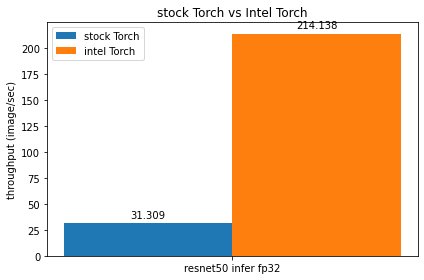

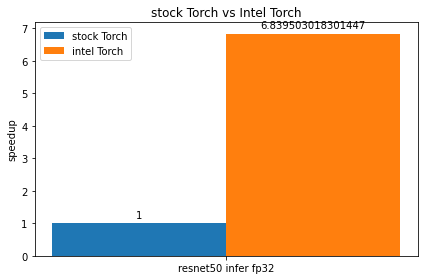

In [18]:
import matplotlib
%matplotlib inline
from profiling.profile_utils import PerfPresenter

perfp=PerfPresenter(True)
# inference  throughput
perfp.draw_perf_diag_from_csv(csv_fname,'throughput','throughput (image/sec)', topology_name)
perfp.draw_perf_ratio_diag_from_csv(csv_fname,'throughput','speedup', topology_name)
if accuracy_only == True:
    perfp.draw_perf_diag_from_csv(csv_fname,'accuracy','accuracy', topology_name)